In [1]:
## Importing Libraries and Downloading Data

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns


from keras.datasets import fashion_mnist
import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: abhijeet001. Use `wandb login --relogin` to force relogin


True

In [3]:
PROJECT_NAME = "FODL_ASSIGNMENT_01_ABHIJEET"

In [4]:
########################################################################################
# Download data
(X, y), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
############################################################################
# # Dataset Preprocessing
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

In [7]:
# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)
##########################################################################

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [8]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

In [9]:
#############################################################

# Number of neurons in the input and output layers
input_nodes = num_features
output_nodes = num_classes

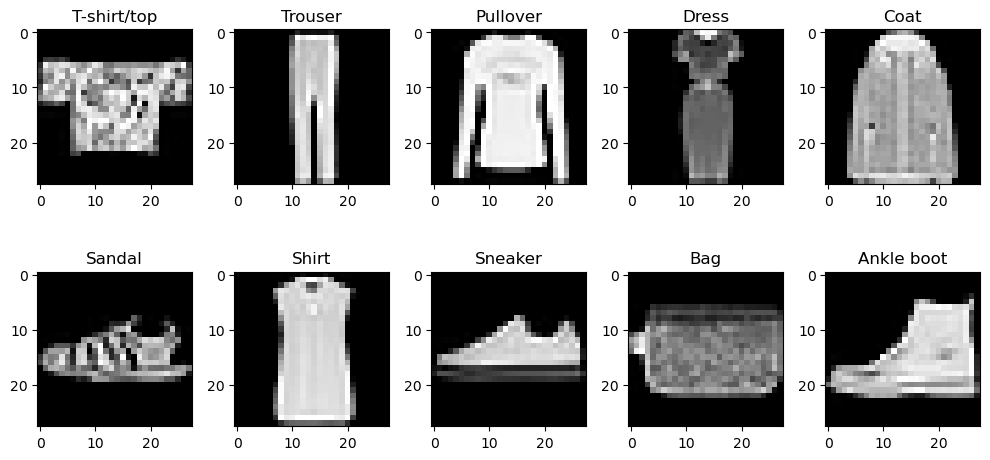

In [10]:
# Number of neurons in the input and output layers
input_nodes = num_features
output_nodes = num_classes

# Class names dictionary
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Print Sample Images
# Store the index of first occurrence of each class
example_indices = [list(y_train).index(i) for i in range(num_classes)]

fig = plt.figure(figsize=(10, 5))
count = 1
for index in example_indices:
    ax = fig.add_subplot(2, 5, count)
    ax.set_title(class_labels[y_train[index]])  # Add title with class name
    ax.imshow(X_train.T[index].reshape((28, 28)), cmap='gray')
    count += 1

plt.tight_layout()
plt.show()

In [11]:
from keras.datasets import fashion_mnist
import wandb

# Initialize Weights & Biases
wandb.init(project="FODL_ASSIGNMENT_01_ABHIJEET")
project_name = PROJECT_NAME

# Define class names for Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the Fashion MNIST dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Normalize pixel values to the range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

def log_images():
    # Initialize lists to store images and their corresponding labels
    set_images = []
    set_labels = []
    count = 0  # Counter to keep track of how many images per class have been added
    for d in range(len(trainy)):
        if trainy[d] == count:
            # Add the image and its label to the respective lists
            set_images.append(trainX[d])
            set_labels.append(class_names[trainy[d]])
            count += 1
        else:
            pass
        if count == 10:
            break  # If images for all 10 classes have been collected, exit the loop

    # Log the images and their labels to Weights & Biases
    image_logs = [wandb.Image(img, caption=caption) for img, caption in zip(set_images, set_labels)]
    wandb.log({"Plot": image_logs})

# Call the function to log images
log_images()

wandb.finish()


In [12]:
# Components of the Neural Network Model
# Activation functions and their derivatives

def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

In [13]:
def compute_loss_function(Y, Y_hat, batch_size, loss, lamb, parameters = None):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size
    
    
    if parameters != None:
        
        #Add L2 regularisation
        acc = 0
        for i in range(1, len(parameters)//2 + 1):
            acc += np.sum(parameters["W"+str(i)]**2)

        L = L + (lamb/(2*batch_size))*acc

    return L

In [14]:
def compute_accuracy(predictions, labels):
    """Compute accuracy given the predicted labels and the true labels."""
    return np.mean(np.argmax(predictions, axis=0) == np.argmax(labels, axis=0))


In [15]:
# Initialize parameters
def initialize_parameters(layer_dims, init_mode="xavier"):
    '''Function to initialise weights, biases and velocities/previous updates of the NN

    Parameters
    ----------
    layer_dims: list
        list of number of neurons per layer specifying layer dimensions in the format [#input_features,#hiddenunits...#hiddenunits,#outputclasses]

    init_mode: string
        initialisation mode, default-"xavier"

    Returns
    -------
    params: dict
        contains weights and biases. eg params[W1] is weight for layer 1

    previous updates: dict
        previous updates initialisation. This is used for different perposes for different optimisers.

    '''
    np.random.seed(42)
    params = {}
    previous_updates = {}

    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
        else:
                
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
                
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

In [16]:
# Forward Propagation
def forward_propagate(X, params, activation_function):
    '''Function to forward propagate a minibatch of data once through the NN

    Parameters
    ----------
    X: numpy array
        data in (features,batch_size) format

    params: dict
        W and b of the NN

    activation_function: string
        activation function to be used except the output layer

    Returns
    -------
    output: numpy array
        contains the output probabilities for each class and each data sample after 1 pass
    A: numpy array
        contains all post-activations
    Z: numpy array
        contsins all pre-activations

    '''
    
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b 
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_function == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_function == 'relu':
                A[l] = Relu(Z[l])
            elif activation_function == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

## BackProp

In [17]:
# Backpropagation

def backprop(y_hat, y,A, Z, params, activation_function, batch_size, loss, lamb):
    '''
    Function to calculate gradients for a minibatch of data once through the NN through backpropagation

    Parameters
    ----------
    y_hat: numpy array
        output from forward propagation/ class probabilities

    y: numpy array
        actual class labels
     
    A: numpy array
        post-activations

    Z: numpy array
        pre-activations   

    params: dict
        contains W and b on the NN   

    activation_function: string
        activation function to be used except the output layer

    batch_size: int
        mini-batch-size

    loss: string
        loss function (MSE/Categorical crossentropy)

    lamb: float
        L2 regularisation lambda

    Returns
    -------
    gradients: dict
        gradients wrt weights and biases

    '''

    L = len(params)//2 #no. of layers
    gradients = {}
    
    #process last layer which has softmax
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    #process other layers
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1: 
            if activation_function == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_function == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_function == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

    ############################################################################################################################

  ## Optimizers

In [18]:
# Optimizers
def update_params_sgd(parameters,grads,learning_rate):
    ''' Update W and b of the NN according to sgd updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    Returns
    -------
    parameters: dict
        updated NN parameters

    '''
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    ''' Update W and b of the NN according to momentum updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    previous_updates: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        previous_updates[Wi] = beta*previous_updates[Wi] + (1-beta)*gradient[dWi]

    Returns
    -------
    parameters: dict
        updated NN parameters

    previous updates: dict
        updated previous updates 

    '''
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):
    ''' Update W and b of the NN according to RMSprop updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients square eg.
        v[Wi] = beta*v[Wi] + (1-beta)*(gradient[dWi]^2)

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated "velocities"

    '''

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    ''' Update W and b of the NN according to adam updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        v[Wi] = beta1*v[Wi] + (1-beta1)*(gradient[dWi])

    m: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients^2 eg.
        v[Wi] = beta2*v[Wi] + (1-beta2)*(gradient[dWi]^2)

    t: int
        timestep for Adam

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated previous updates

    m: dict
        updated "velocities"

    t: int
        updated timestep

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9 #default
    beta2 = 0.999 #default
    epsilon = 1e-8 #for numerical stability

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t


## Function to plot the cost curves

In [19]:
# Function to plot the cost curves
def plot_cost_curve(train_costs, val_costs):
    '''
    Plots the train and validation cost curves
    '''
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

## Prediction and Evaluation functions

In [20]:
# Prediction and Evaluation functions

def NN_predict(X_test, params, activation_function):
    '''
    forward propagate once and calculate labels

    '''
    output, _, _ = forward_propagate(X_test, params, activation_function)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_function):
    '''
    print train,test accuracies and the classification report using sklearn

    '''
    train_predictions = NN_predict(X_train, params, activation_function)
    test_predictions = NN_predict(X_test, params, activation_function)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

## NEURAL_NETWORK

In [21]:
########################################################################################################################
# Training on the full dataset

def NN_fit(X_train, y_train_one_hot,X_val,y_val_one_hot, learning_rate = 0.001, activation_function = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                layer_dims=[], num_layers = 3, hidden_size = 32):
    """This function is used to train the neural network on the dataset 

    X_train: numpy array
        train dataset

    y_train_one_hot: numpy array
        train labels with one-hot encoding

    learning_rate: float

    activation_function: string
        activation functions for all the layers except the last layer which is softmax

    init_mode: string
        initialization mode
    
    optimizer: string
        optimization routine

    bach_size: int
        minibatch size

    loss: string
        loss function

    epochs: int
        number of epochs to be used

    L2_lamb: float
        lambda for L2 regularisation of weights

    num_neurons: int
        number of neurons in every hidden layer

    num_hidden: 
        number of hidden layers

    Returns
    -------

    parameters: dict
        weights and biases of the NN model

    epoch_cost: list
        training costs with every epoch
    

    """

    layer_dims = [hidden_size for i in range(num_layers)]
    layer_dims[0] = X_train.shape[0]
    layer_dims[num_layers - 1] =  10
    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost=[]
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs

        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1
            
            #process all nesterov accelerated optimisers

            #NAG
            if optimizer == 'nesterov':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_function, batch_count, loss, L2_lamb)

                #call momentum
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)

            #nadam
            elif optimizer=='nadam':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_function, batch_count, loss, L2_lamb)

                #call adam
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)



            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_function, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

                #custom
                elif optimizer == 'insert your optimiser here':
                    #insert your optimiser update routine only if it does not have nesterov 
                    pass

                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_function)
        cost = compute_loss_function(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        train_accuracy = compute_accuracy(full_output, y_train_one_hot)
        
        
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_function)
        val_cost = compute_loss_function(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)
        
        val_accuracy = compute_accuracy(out, y_val_one_hot)

        
        
        

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)
            
        
#         with wandb.init():
        wandb.log({"epoch" : count-1,
                   "train_loss": cost, 
                    "val_loss": val_cost, 
                    "train_accuracy": train_accuracy, 
                    "val_accuracy": val_accuracy})


    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)


    return params, epoch_cost




In [22]:
########################################################################################################################
# Training on the full dataset

def NN_fit_w(X_train, y_train_one_hot,X_val,y_val_one_hot, learning_rate = 0.001, activation_function = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                layer_dims=[], num_layers = 3, hidden_size = 32):
    """This function is used to train the neural network on the dataset 

    X_train: numpy array
        train dataset

    y_train_one_hot: numpy array
        train labels with one-hot encoding

    learning_rate: float

    activation_function: string
        activation functions for all the layers except the last layer which is softmax

    init_mode: string
        initialization mode
    
    optimizer: string
        optimization routine

    bach_size: int
        minibatch size

    loss: string
        loss function

    epochs: int
        number of epochs to be used

    L2_lamb: float
        lambda for L2 regularisation of weights

    num_neurons: int
        number of neurons in every hidden layer

    num_hidden: 
        number of hidden layers

    Returns
    -------

    parameters: dict
        weights and biases of the NN model

    epoch_cost: list
        training costs with every epoch
    

    """

    layer_dims = [hidden_size for i in range(num_layers)]
    layer_dims[0] = X_train.shape[0]
    layer_dims[num_layers - 1] =  10
    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost=[]
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs

        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1
            
            #process all nesterov accelerated optimisers

            #NAG
            if optimizer == 'nesterov':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_function, batch_count, loss, L2_lamb)

                #call momentum
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)

            #nadam
            elif optimizer=='nadam':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_function, batch_count, loss, L2_lamb)

                #call adam
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)


            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_function)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_function, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

                #custom
                elif optimizer == 'insert your optimiser here':
                    #insert your optimiser update routine only if it does not have nesterov 
                    pass

                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_function)
        cost = compute_loss_function(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        train_accuracy = compute_accuracy(full_output, y_train_one_hot)
        
        
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_function)
        val_cost = compute_loss_function(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)
        
        val_accuracy = compute_accuracy(out, y_val_one_hot)

        
        
        

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)
            
        
# #         with wandb.init():
#         wandb.log({"epoch" : count,
#                    "train_loss": cost, 
#                     "val_loss": val_cost, 
#                     "train_accuracy": train_accuracy, 
#                     "val_accuracy": val_accuracy})


    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)


    return params, epoch_cost




### Hyperparameter tuning using WandB.

In [23]:
def obj(config):
    learned_parameters, epoch_cost = NN_fit(X_train, y_train_one_hot,
                                X_val,y_val_one_hot,
                                learning_rate=config.learning_rate,
                                activation_function = config.activation_function,
                                init_mode = config.init_mode,
                                optimizer = config.optimizer,
                                batch_size = config.batch_size,
                                loss = config.loss,
                                epochs = config.epochs,
                                L2_lamb = config.L2_lamb,
                                num_layers=config.num_layers,
                                hidden_size=config.hidden_size)
#     # return epoch_cost[-1]
#     return [acc, val_acc, loss, val_loss]

Create sweep with ID: thjrce4n
Sweep URL: https://wandb.ai/abhijeet001/FODL_ASSIGNMENT_01_ABHIJEET/sweeps/thjrce4n


wandb: Agent Starting Run: nik6ox6g with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.327745497447504
Epoch number:  4 	Training cost: 2.327745497447504
Epoch number:  6 	Training cost: 2.327745497447504
Epoch number:  8 	Training cost: 2.327745497447504
Epoch number:  10 	Training cost: 2.327745497447504
Epoch number:  12 	Training cost: 2.327745497447504
Epoch number:  14 	Training cost: 2.327745497447504
Epoch number:  16 	Training cost: 2.327745497447504


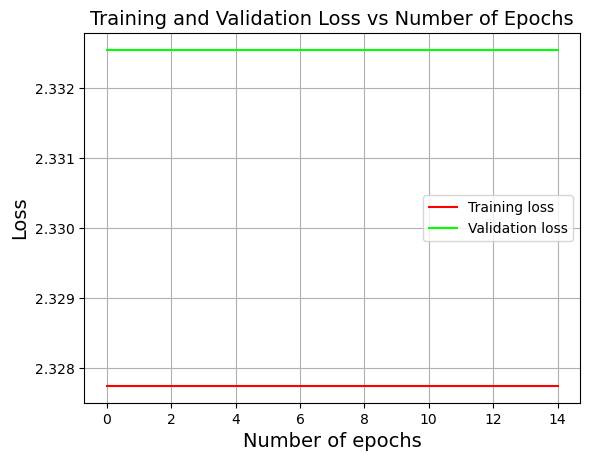

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.07281
train_loss,2.32775
val_accuracy,0.07433
val_loss,2.33254


wandb: Agent Starting Run: o3dbg7m4 with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.472449369533402
Epoch number:  4 	Training cost: 2.472449369533402
Epoch number:  6 	Training cost: 2.472449369533402
Epoch number:  8 	Training cost: 2.472449369533402
Epoch number:  10 	Training cost: 2.472449369533402
Epoch number:  12 	Training cost: 2.472449369533402
Epoch number:  14 	Training cost: 2.472449369533402
Epoch number:  16 	Training cost: 2.472449369533402


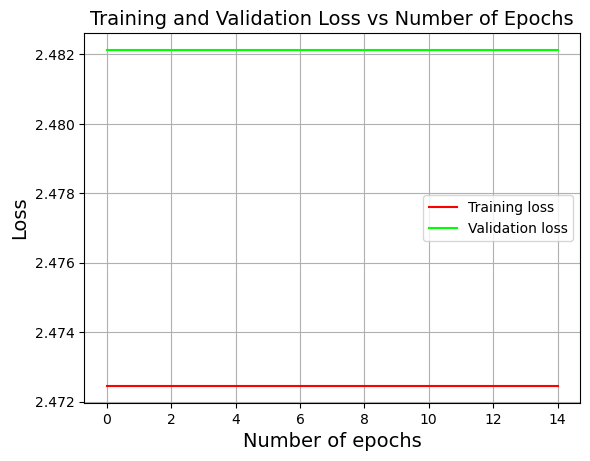

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09824
train_loss,2.47245
val_accuracy,0.10167
val_loss,2.48213


wandb: Agent Starting Run: wkru8777 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.1806694314516806
Epoch number:  4 	Training cost: 1.800705961903664
Epoch number:  6 	Training cost: 1.5489560696395335


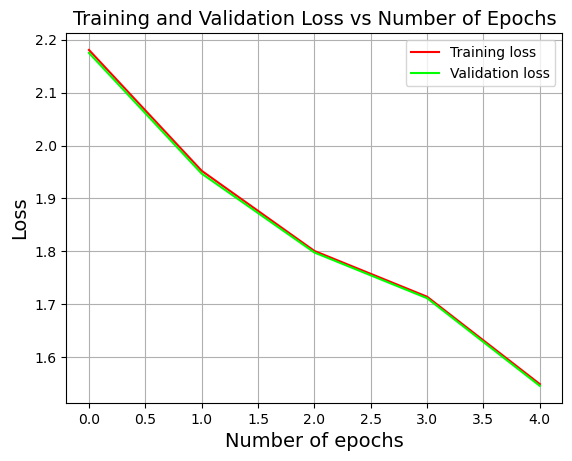

epoch,▁▃▅▆█
train_accuracy,▁▄▅▅█
train_loss,█▅▄▃▁
val_accuracy,▁▃▄▅█
val_loss,█▅▄▃▁
epoch,5
train_accuracy,0.39757
train_loss,1.54896
val_accuracy,0.404
val_loss,1.54559


wandb: Agent Starting Run: nd2c93h1 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.6058292513967658
Epoch number:  4 	Training cost: 0.4574426842099607
Epoch number:  6 	Training cost: 0.41234367371096325
Epoch number:  8 	Training cost: 0.38600014036428565
Epoch number:  10 	Training cost: 0.36713514367251165


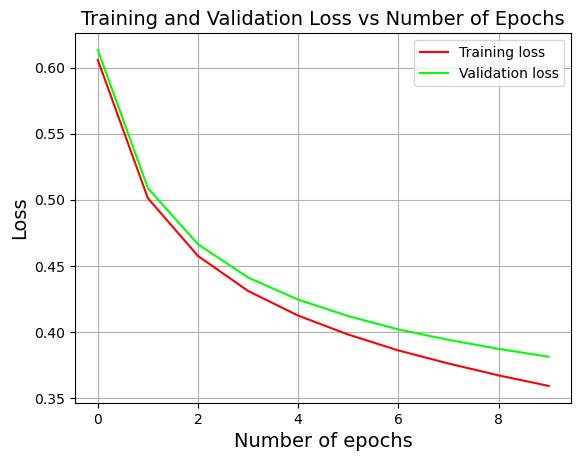

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.87431
train_loss,0.35916
val_accuracy,0.86583
val_loss,0.38124


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wmzvsz2x with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.7985383822671133
Epoch number:  4 	Training cost: 0.7985208943851257
Epoch number:  6 	Training cost: 1.4558624282367294
Epoch number:  8 	Training cost: 1.5538696012931348
Epoch number:  10 	Training cost: 0.883717293058088
Epoch number:  12 	Training cost: 1.1611369594305423
Epoch number:  14 	Training cost: 0.840322848080397
Epoch number:  16 	Training cost: 0.8337470844975736


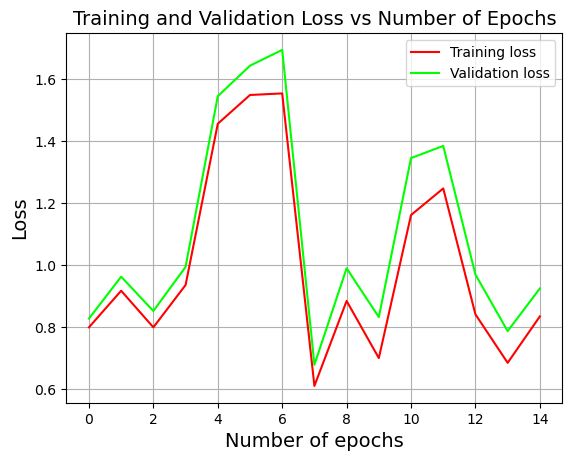

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▆▆▂▃▄█▄▇▆▃▆█▅
train_loss,▂▃▂▃▇██▁▃▂▅▆▃▂▃
val_accuracy,▁▃▅▆▂▃▄█▅▇▆▃▆█▅
val_loss,▂▃▂▃▇██▁▃▂▆▆▃▂▃
epoch,15
train_accuracy,0.79928
train_loss,0.83375
val_accuracy,0.79233
val_loss,0.92393


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oqt6ac4x with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.7985383822671133
Epoch number:  4 	Training cost: 0.7985208943851257
Epoch number:  6 	Training cost: 1.4558624282367294
Epoch number:  8 	Training cost: 1.5538696012931348
Epoch number:  10 	Training cost: 0.883717293058088


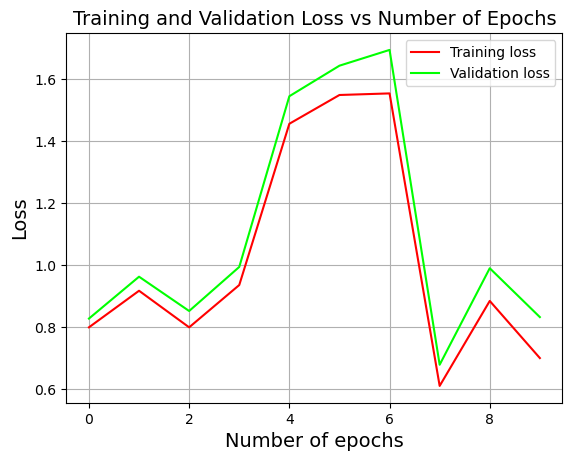

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▆▂▃▄█▄▇
train_loss,▂▃▂▃▇██▁▃▂
val_accuracy,▁▃▅▆▂▃▄█▅▇
val_loss,▂▃▂▃▇██▁▃▂
epoch,10
train_accuracy,0.82907
train_loss,0.69928
val_accuracy,0.81733
val_loss,0.83155


wandb: Agent Starting Run: vj2bigu4 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.32649473881536
Epoch number:  4 	Training cost: 2.32649473881536
Epoch number:  6 	Training cost: 2.32649473881536
Epoch number:  8 	Training cost: 2.32649473881536
Epoch number:  10 	Training cost: 2.32649473881536
Epoch number:  12 	Training cost: 2.32649473881536
Epoch number:  14 	Training cost: 2.32649473881536
Epoch number:  16 	Training cost: 2.32649473881536


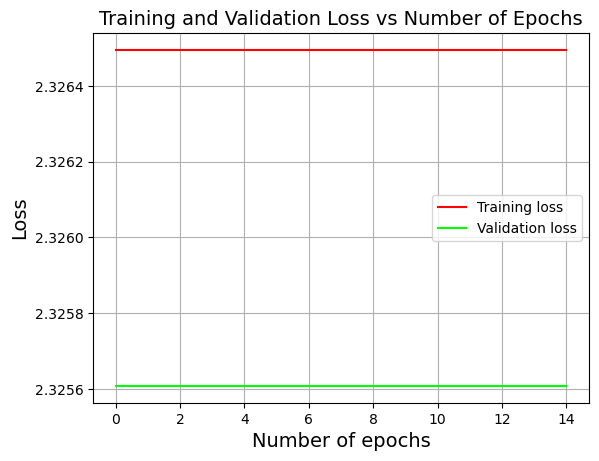

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.12457
train_loss,2.32649
val_accuracy,0.12767
val_loss,2.32561


wandb: Agent Starting Run: ohb957wk with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.9232328048925728
Epoch number:  4 	Training cost: 0.6204599295385586
Epoch number:  6 	Training cost: 0.5306381775214668
Epoch number:  8 	Training cost: 0.4905422407570035
Epoch number:  10 	Training cost: 0.4672712341038664
Epoch number:  12 	Training cost: 0.45117011615142893
Epoch number:  14 	Training cost: 0.4387090431714712
Epoch number:  16 	Training cost: 0.42831329670943025


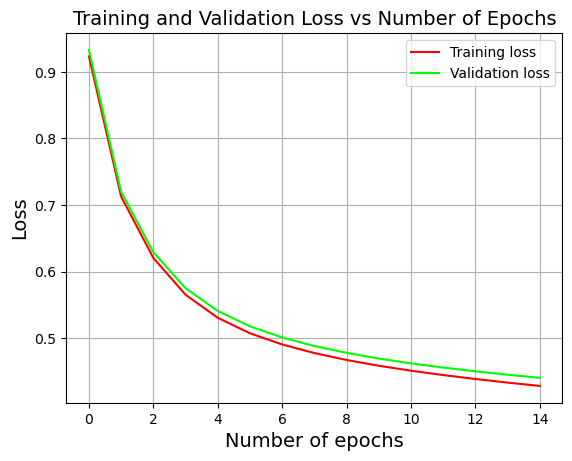

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▆▆▇▇▇▇▇██████
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇████████
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.8518
train_loss,0.42831
val_accuracy,0.84067
val_loss,0.4405


wandb: Agent Starting Run: gc8avsrz with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.38295459349365557
Epoch number:  4 	Training cost: 0.32434702372173696
Epoch number:  6 	Training cost: 0.30438077535867647


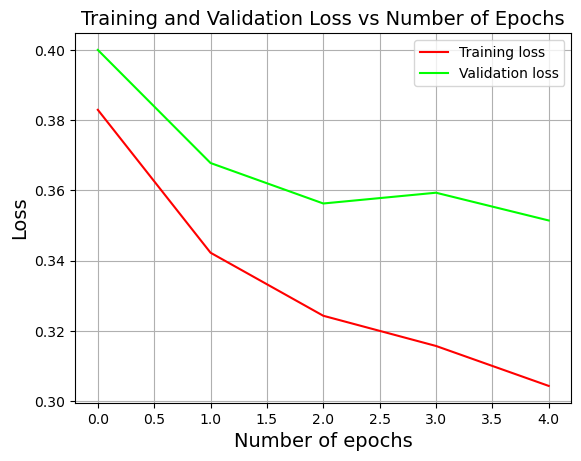

epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▇█▇
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.8892
train_loss,0.30438
val_accuracy,0.8745
val_loss,0.35146


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: utzzdebt with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.7627822342140973
Epoch number:  4 	Training cost: 0.5606023199646184
Epoch number:  6 	Training cost: 0.5016987509431946


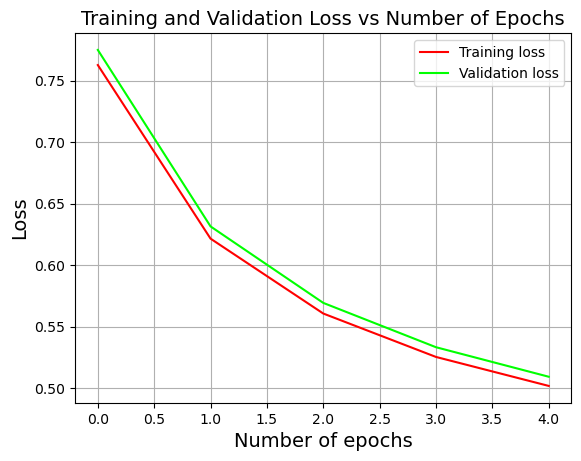

epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.8262
train_loss,0.5017
val_accuracy,0.82167
val_loss,0.50917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qoc8nfrx with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.297354530574938
Epoch number:  4 	Training cost: 2.2784976687827974
Epoch number:  6 	Training cost: 2.099592548032959
Epoch number:  8 	Training cost: 1.6991051146156224
Epoch number:  10 	Training cost: 1.4756388511693697


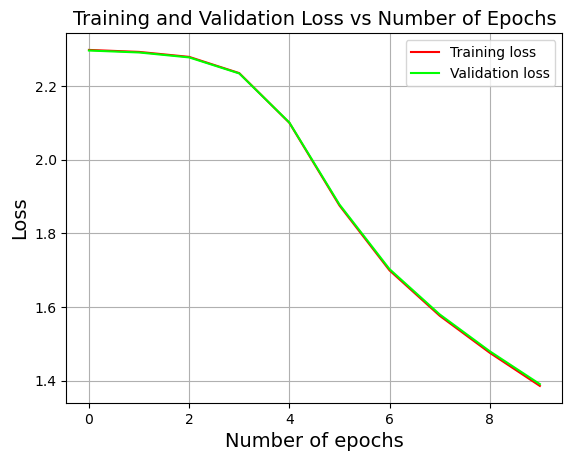

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▃▄▅▆▇██
train_loss,████▆▅▃▂▂▁
val_accuracy,▁▁▁▃▄▅▆▇██
val_loss,████▆▅▃▂▂▁
epoch,10
train_accuracy,0.55844
train_loss,1.38566
val_accuracy,0.55833
val_loss,1.39055


wandb: Agent Starting Run: bsdvvupi with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.477055446120218
Epoch number:  4 	Training cost: 2.477055446120218
Epoch number:  6 	Training cost: 2.477055446120218
Epoch number:  8 	Training cost: 2.477055446120218
Epoch number:  10 	Training cost: 2.477055446120218
Epoch number:  12 	Training cost: 2.477055446120218
Epoch number:  14 	Training cost: 2.477055446120218
Epoch number:  16 	Training cost: 2.477055446120218


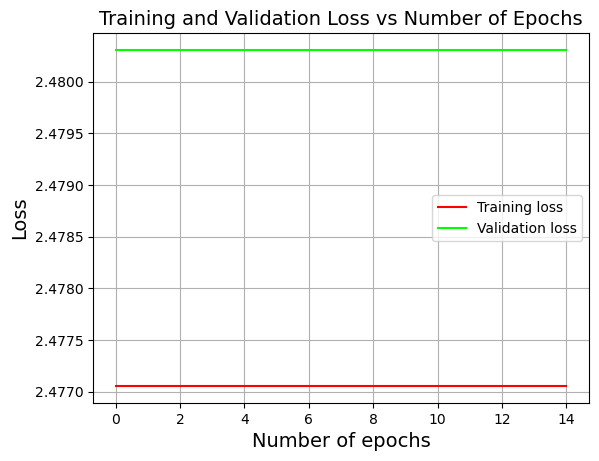

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.0995
train_loss,2.47706
val_accuracy,0.1045
val_loss,2.48031


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cd9sbsxd with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.3026196264877075
Epoch number:  4 	Training cost: 2.3026196264877075
Epoch number:  6 	Training cost: 2.3026196264877075


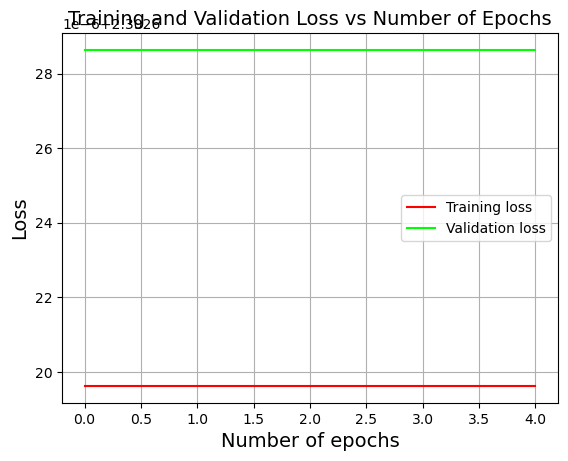

epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.0998
train_loss,2.30262
val_accuracy,0.10183
val_loss,2.30263


wandb: Agent Starting Run: 2tsygjfr with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.3033856864434035
Epoch number:  4 	Training cost: 2.3033856864434035
Epoch number:  6 	Training cost: 2.3033856864434035
Epoch number:  8 	Training cost: 2.3033856864434035
Epoch number:  10 	Training cost: 2.3033856864434035


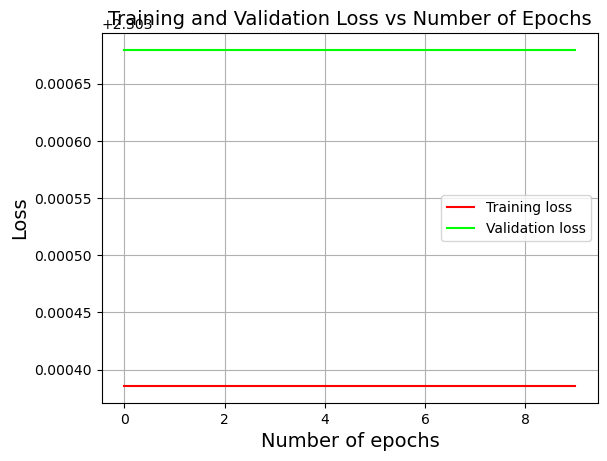

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10019
train_loss,2.30339
val_accuracy,0.09833
val_loss,2.30368


wandb: Agent Starting Run: 546pkxt2 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.303337176203581
Epoch number:  4 	Training cost: 2.303337176203581
Epoch number:  6 	Training cost: 2.303337176203581
Epoch number:  8 	Training cost: 2.303337176203581
Epoch number:  10 	Training cost: 2.303337176203581


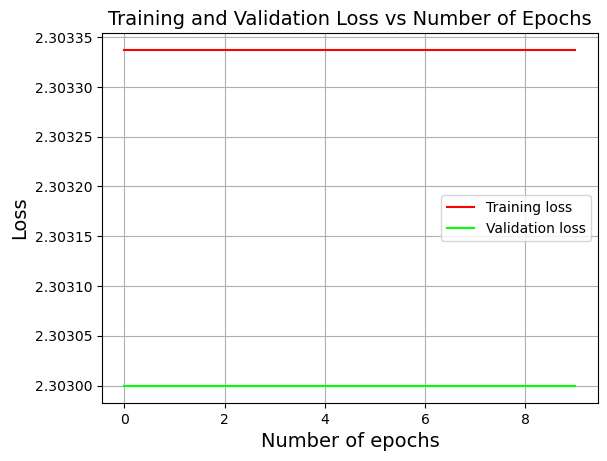

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10019
train_loss,2.30334
val_accuracy,0.09833
val_loss,2.303


wandb: Agent Starting Run: rn17vpe6 with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.01
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.1852359507889134
Epoch number:  4 	Training cost: 1.80209211695795
Epoch number:  6 	Training cost: 1.6524791224788165
Epoch number:  8 	Training cost: 1.5565069185091978
Epoch number:  10 	Training cost: 1.484861599533464


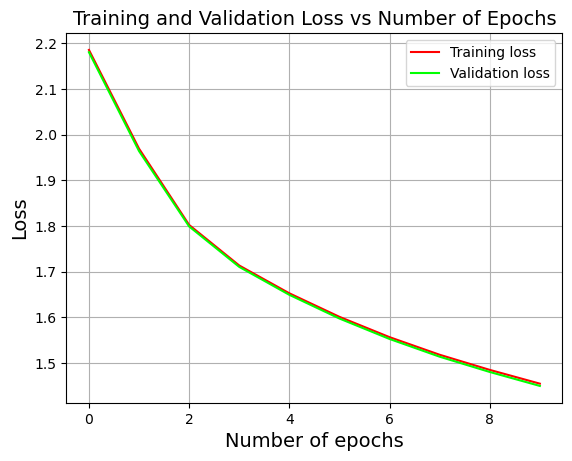

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.38156
train_loss,1.45472
val_accuracy,0.38367
val_loss,1.44978


wandb: Agent Starting Run: falg4iey with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: nan
Epoch number:  4 	Training cost: nan
Epoch number:  6 	Training cost: nan
Epoch number:  8 	Training cost: nan
Epoch number:  10 	Training cost: nan


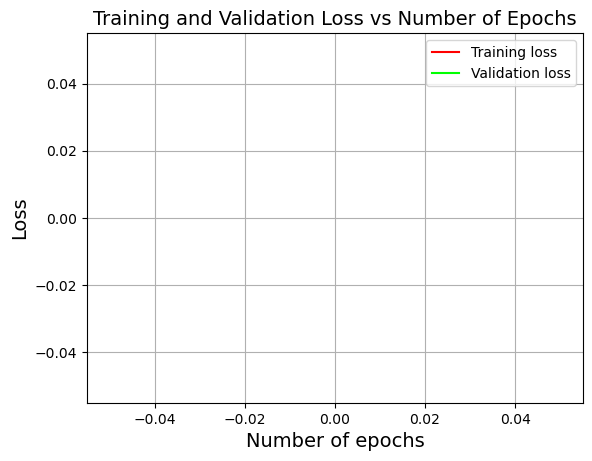

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10006
train_loss,nan
val_accuracy,0.0995
val_loss,nan


wandb: Agent Starting Run: uxyu0pev with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.5670936955025928
Epoch number:  4 	Training cost: 0.40188830185585367
Epoch number:  6 	Training cost: 0.3589017722396095
Epoch number:  8 	Training cost: 0.33610716599190243
Epoch number:  10 	Training cost: 0.3212363879729162
Epoch number:  12 	Training cost: 0.3051532716253411
Epoch number:  14 	Training cost: 0.29558478503248947
Epoch number:  16 	Training cost: 0.289639512297699


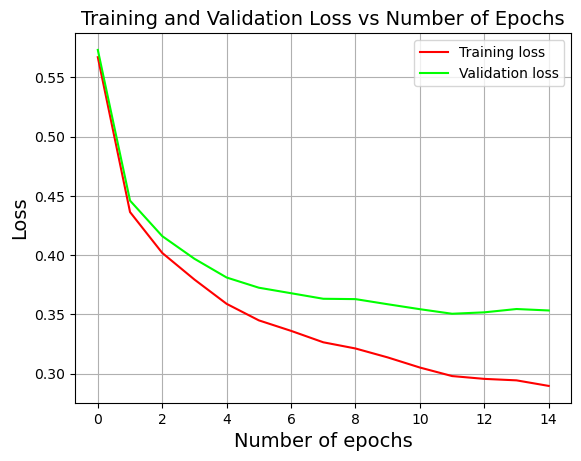

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89343
train_loss,0.28964
val_accuracy,0.87483
val_loss,0.35332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oy37pejw with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.572173633030645
Epoch number:  4 	Training cost: 0.4566673117640582
Epoch number:  6 	Training cost: 0.42875811191810587
Epoch number:  8 	Training cost: 0.4139821188955774
Epoch number:  10 	Training cost: 0.40439532123252236
Epoch number:  12 	Training cost: 0.3974324338793715
Epoch number:  14 	Training cost: 0.39206969855899815
Epoch number:  16 	Training cost: 0.3878207000966384


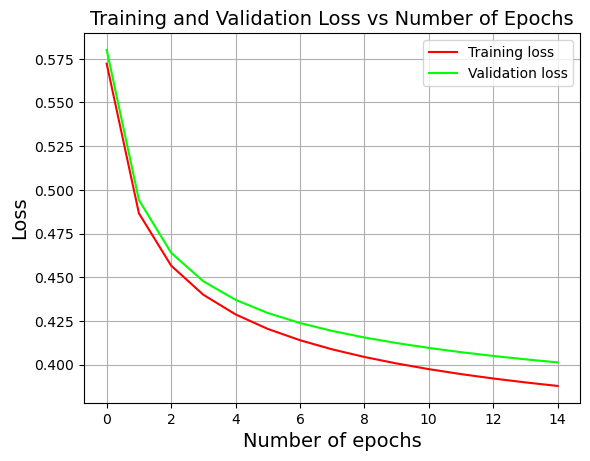

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇▇█████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.86643
train_loss,0.38782
val_accuracy,0.8575
val_loss,0.4013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rnxs6itu with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.455768246668575
Epoch number:  4 	Training cost: 2.455768246668575
Epoch number:  6 	Training cost: 2.455768246668575
Epoch number:  8 	Training cost: 2.455768246668575
Epoch number:  10 	Training cost: 2.455768246668575


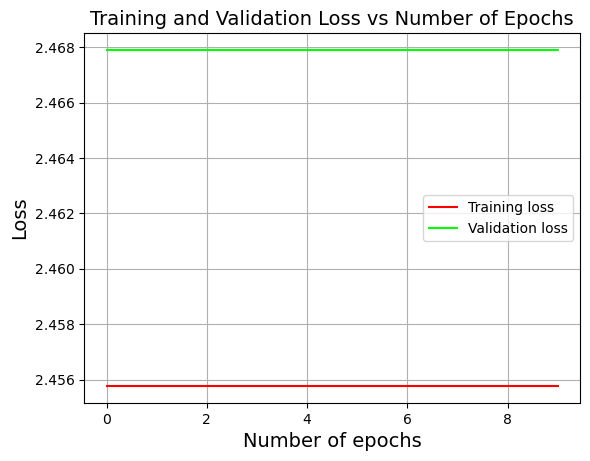

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.12902
train_loss,2.45577
val_accuracy,0.1235
val_loss,2.4679


wandb: Agent Starting Run: ter4tg84 with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.01
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 1.802326818286177
Epoch number:  4 	Training cost: 1.4475171955507746
Epoch number:  6 	Training cost: 1.2904950880757624


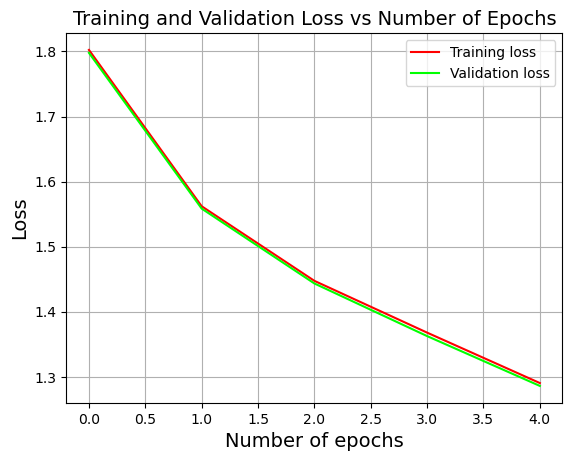

epoch,▁▃▅▆█
train_accuracy,▁▄▆▆█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.46983
train_loss,1.2905
val_accuracy,0.461
val_loss,1.2861


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yp3booln with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.1
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 7.0519744282756935
Epoch number:  4 	Training cost: 2.8150726474188197
Epoch number:  6 	Training cost: 2.1439875897612035
Epoch number:  8 	Training cost: 3.2494293723840717
Epoch number:  10 	Training cost: 2.449448679477307
Epoch number:  12 	Training cost: 3.5444887893912993
Epoch number:  14 	Training cost: 2.042621691276822
Epoch number:  16 	Training cost: 2.6425862339734794


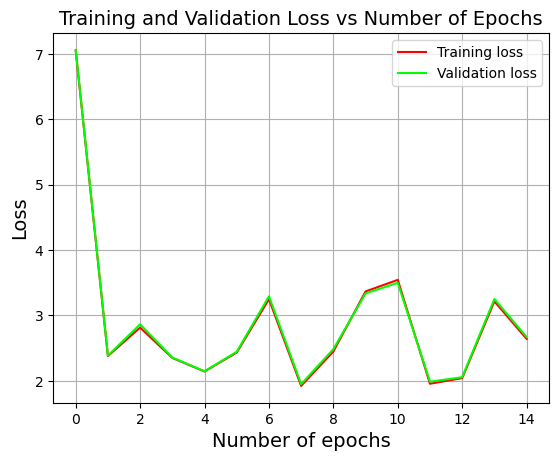

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▁▇▁▁▇▆▂▂█▆▁▃
train_loss,█▂▂▂▁▂▃▁▂▃▃▁▁▃▂
val_accuracy,▂▁▂▁▇▂▁▇▇▃▃█▇▁▃
val_loss,█▂▂▂▁▂▃▁▂▃▃▁▁▃▂
epoch,15
train_accuracy,0.13191
train_loss,2.64259
val_accuracy,0.12267
val_loss,2.67084


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzquupp6 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.6601098273917761
Epoch number:  4 	Training cost: 0.639341893152599
Epoch number:  6 	Training cost: 0.6368825587835973


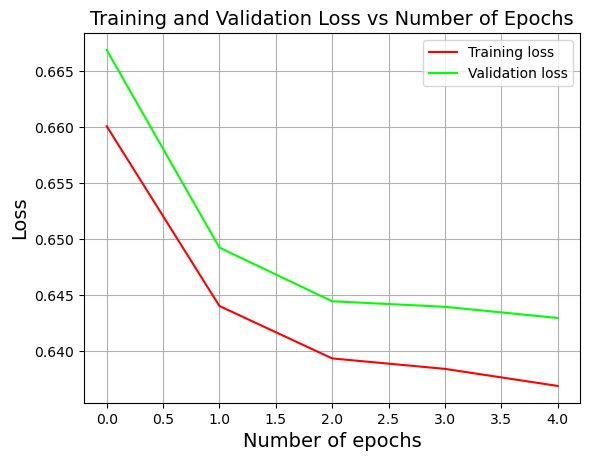

epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▇███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.76507
train_loss,0.63688
val_accuracy,0.76167
val_loss,0.64296


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0j82xxz2 with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.41794835131884234
Epoch number:  4 	Training cost: 0.36321313741645833
Epoch number:  6 	Training cost: 0.341712014339916
Epoch number:  8 	Training cost: 0.32225120374740107
Epoch number:  10 	Training cost: 0.3108206531696519
Epoch number:  12 	Training cost: 0.3050712578145812
Epoch number:  14 	Training cost: 0.3059511528008545
Epoch number:  16 	Training cost: 0.3063000649166118


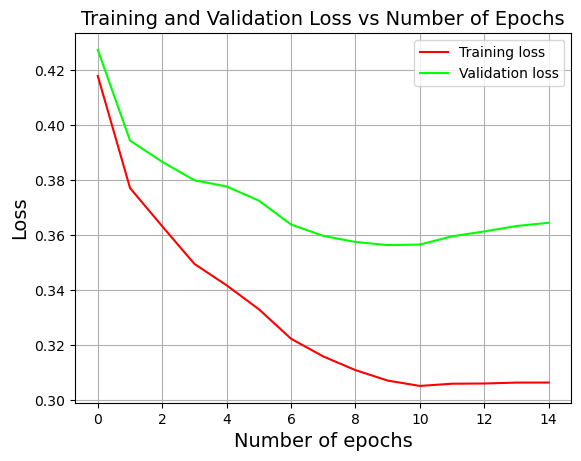

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▆▆▇▇███████
train_loss,█▅▅▄▃▃▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▇▇█▇▇▇▆
val_loss,█▅▄▃▃▃▂▁▁▁▁▁▁▂▂
epoch,15
train_accuracy,0.89039
train_loss,0.3063
val_accuracy,0.86983
val_loss,0.36451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nrxjoq15 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.302505189565872
Epoch number:  4 	Training cost: 2.302411450337942
Epoch number:  6 	Training cost: 2.30232441940169
Epoch number:  8 	Training cost: 2.3022251311452075
Epoch number:  10 	Training cost: 2.302100729139465


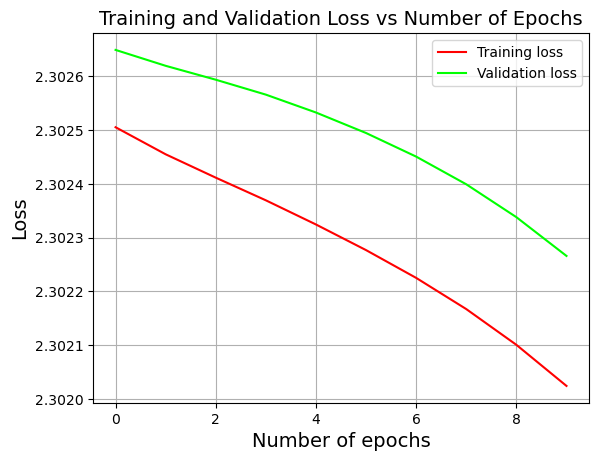

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
train_accuracy,0.10093
train_loss,2.30202
val_accuracy,0.09167
val_loss,2.30227


wandb: Agent Starting Run: qntdhhkv with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.302582023063541
Epoch number:  4 	Training cost: 2.3025799704334218
Epoch number:  6 	Training cost: 2.3025784743063817
Epoch number:  8 	Training cost: 2.302577408716238
Epoch number:  10 	Training cost: 2.302576570087338


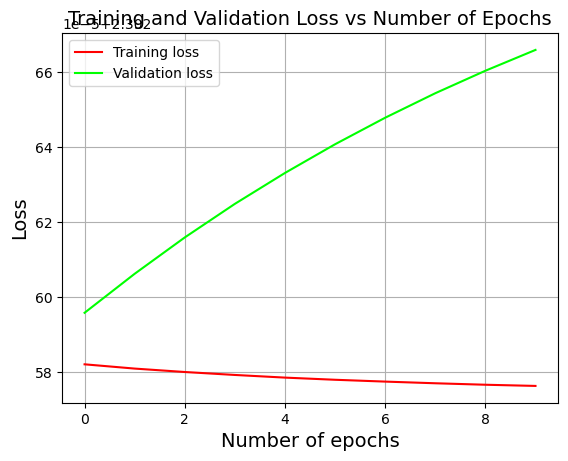

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▄▃▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▅▆▇▇█
epoch,10
train_accuracy,0.10093
train_loss,2.30258
val_accuracy,0.09167
val_loss,2.30267


wandb: Agent Starting Run: gem8r0x8 with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.2579712805961942
Epoch number:  4 	Training cost: 2.0687234731762922
Epoch number:  6 	Training cost: 1.8843436857059803
Epoch number:  8 	Training cost: 1.7869519913454435
Epoch number:  10 	Training cost: 1.719671308270137
Epoch number:  12 	Training cost: 1.6686933522293452
Epoch number:  14 	Training cost: 1.627515997785445
Epoch number:  16 	Training cost: 1.5888716045176285


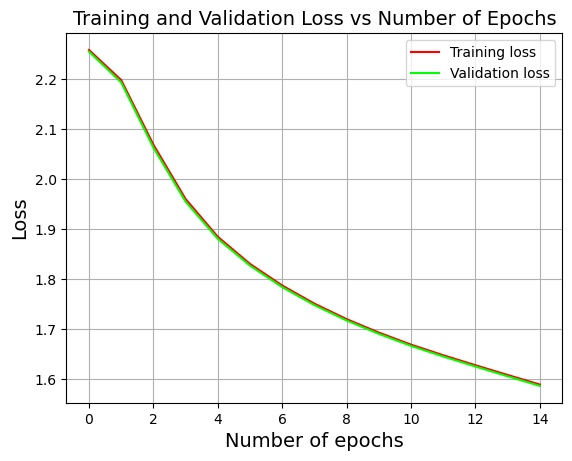

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▅▆▆▇▇▇▇▇████
train_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▅▆▇▇▇▇▇████
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
epoch,15
train_accuracy,0.34102
train_loss,1.58887
val_accuracy,0.34083
val_loss,1.58613


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5geupvra with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: mse
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.395597507615892
Epoch number:  4 	Training cost: 2.395597507615892
Epoch number:  6 	Training cost: 2.395597507615892


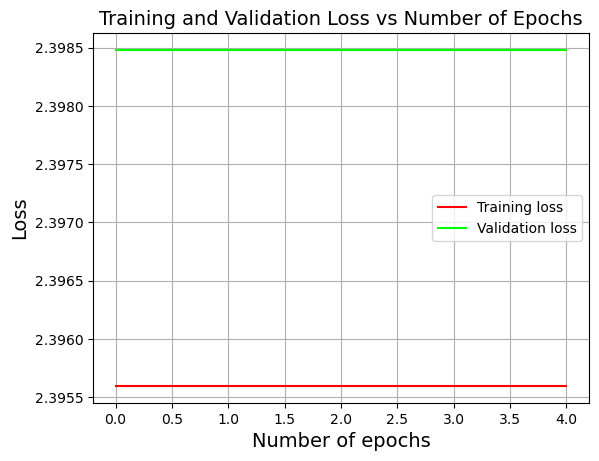

epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.1092
train_loss,2.3956
val_accuracy,0.10683
val_loss,2.39848


wandb: Agent Starting Run: xk5ygqzo with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 0.41939818192921174
Epoch number:  4 	Training cost: 0.3674089644579052
Epoch number:  6 	Training cost: 0.3481238324223715
Epoch number:  8 	Training cost: 0.3424702154085284
Epoch number:  10 	Training cost: 0.3397768472406314


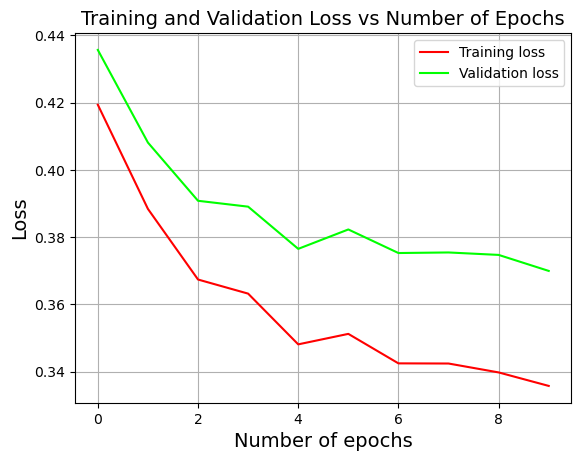

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▆█▇▇███
val_loss,█▅▃▃▂▂▂▂▂▁
epoch,10
train_accuracy,0.87898
train_loss,0.33576
val_accuracy,0.86667
val_loss,0.36997


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fu5x1vkb with config:
wandb: 	L2_lamb: 0.005
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.1
wandb: 	loss: categorical_crossentropy
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.3793796894017483
Epoch number:  4 	Training cost: 2.3997266408906466
Epoch number:  6 	Training cost: 2.411178342150924
Epoch number:  8 	Training cost: 2.4214744293241215
Epoch number:  10 	Training cost: 2.3909815949548676


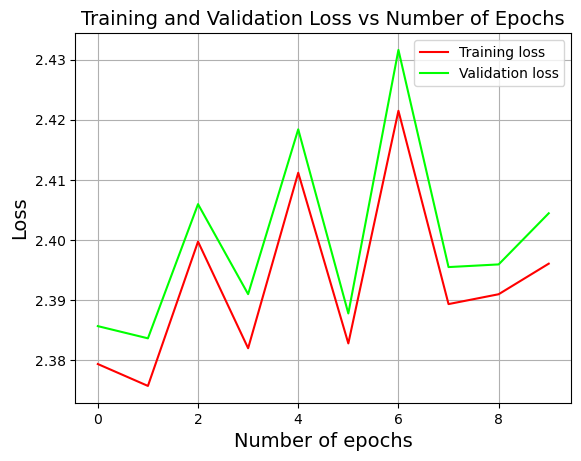

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▁▁▆▁█▁▁▆
train_loss,▂▁▅▂▆▂█▃▃▄
val_accuracy,█▃██▃█▁██▃
val_loss,▁▁▄▂▆▂█▃▃▄
epoch,10
train_accuracy,0.10006
train_loss,2.39606
val_accuracy,0.0995
val_loss,2.40444


In [24]:
import wandb

# Define your project name
project_name = PROJECT_NAME

# Define your obj function
def main():
    wandb.init(project="FODL_ASSIGNMENT_01_ABHIJEET")
    config = wandb.config  # Access configuration
    run_name = f"lr:{config.learning_rate}__activation:{config.activation_function}__init_mode:{config.init_mode}__optimizer:{config.optimizer}__batch_size:{config.batch_size}__loss:{config.loss}__epochs:{config.epochs}__L2_lamb:{config.L2_lamb}__num_layers={config.num_layers}__hidden_size:{config.hidden_size}"
#     wandb.init(name=f"lr:{config.learning_rate}__activation:{config.activation_function}__init_mode:{config.init_mode}__optimizer:{config.optimizer}__batch_size:{config.batch_size}__loss:{config.loss}__epochs:{config.epochs}__L2_lamb:{config.L2_lamb}__num_layers={config.num_layers}__hidden_size:{config.hidden_size}")
    wandb.run.name = run_name
    obj(wandb.config)

# Define your sweep configuration
sweep_configuration = {
    'method': 'bayes',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {'values': [5, 10, 15]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128, 256, 512]},
        'weight_decay': {'values': [0, 0.0005]},
        'learning_rate': {'values': [0.1, 0.01, 0.001]},
        'optimizer': {'values': ['sgd', 'momentum', 'rmsprop', 'adam']},
        'batch_size': {'values': [16, 32, 64]},
        'init_mode': {'values': ['random_normal', 'random_uniform', 'xavier']},
        'activation_function': {'values': ['sigmoid', 'tanh', 'relu']},
        'loss': {'values': ['mse', 'categorical_crossentropy']},
        'L2_lamb': {'values': [0.05, 0.005]}
    }
}

# Define and start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project=project_name)
wandb.agent(sweep_id, function=main, count=30)


### Result Using Tuned Hyperparameter tuning using WandB.

Epoch number:  2 	Training cost: 0.4479346969614187
Epoch number:  4 	Training cost: 0.3682492808516544
Epoch number:  6 	Training cost: 0.33547054676437604
Epoch number:  8 	Training cost: 0.31336071077460403
Epoch number:  10 	Training cost: 0.29620399194524694
Epoch number:  12 	Training cost: 0.2821079249453098
Epoch number:  14 	Training cost: 0.2701711042861179
Epoch number:  16 	Training cost: 0.2599019343013782


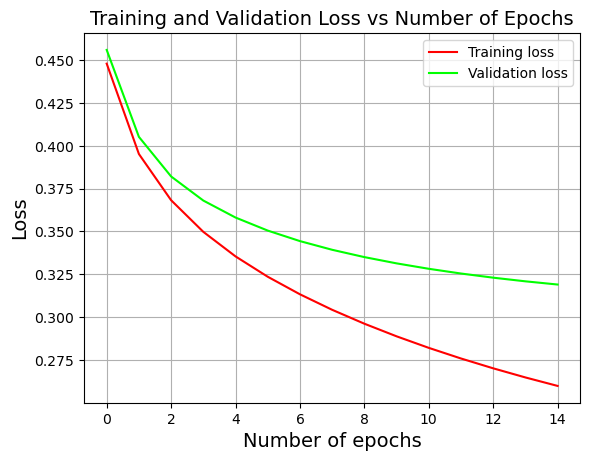

In [25]:
# Hyperparameter config1

# VAL_ACCURACY_1 = 0.885
L2_lambda_1 = 0.005
ACTIVATION_1 = "tanh"
BATCH_SIZE_1 = 64
EPOCHS_1 = 15
HIDDEN_SIZE_1 = 128
INITIALIZER_1 = "xavier"
LEARNING_RATE_1 = 0.1
LOSS_1 = 'cross-entropy'
NUM_LAYERS_1 = 3
OPTIMIZER_1 = "sgd"
WEIGHT_DECAY_1 = 0.0005

# Learned parameters
learned_parameters_best, epoch_cost_best = NN_fit_w(X_train, y_train_one_hot,
                            X_val, y_val_one_hot,
                            learning_rate=LEARNING_RATE_1,
                            activation_function=ACTIVATION_1,
                            init_mode=INITIALIZER_1,
                            optimizer=OPTIMIZER_1,
                            batch_size=BATCH_SIZE_1,
                            loss=LOSS_1,
                            epochs=EPOCHS_1,
                            L2_lamb=L2_lambda_1,
                            num_layers=NUM_LAYERS_1,
                            hidden_size=HIDDEN_SIZE_1)


Epoch number:  2 	Training cost: 0.4277494555074971
Epoch number:  4 	Training cost: 0.34359255390214627
Epoch number:  6 	Training cost: 0.30933342267350417
Epoch number:  8 	Training cost: 0.29571801834985983
Epoch number:  10 	Training cost: 0.2686074703203968
Epoch number:  12 	Training cost: 0.2552207503936151
Epoch number:  14 	Training cost: 0.24321685501060025
Epoch number:  16 	Training cost: 0.23701820208263233


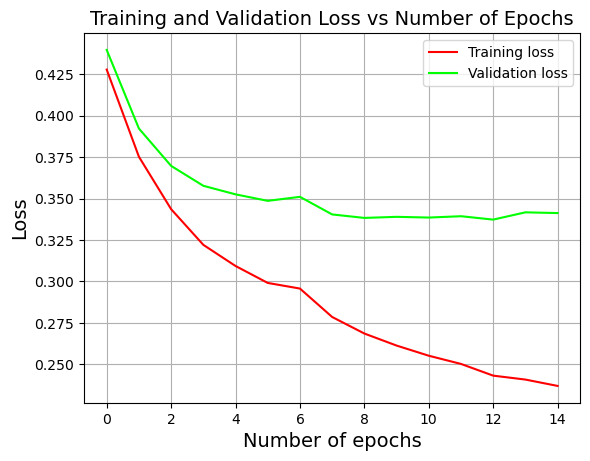

In [26]:
# Hyperparameter config2

VAL_ACCURACY_2 = 0.8847
L2_lambda_2 = 0.005
ACTIVATION_2 = "relu"
BATCH_SIZE_2 = 64
EPOCHS_2 = 15
HIDDEN_SIZE_2 = 128
INITIALIZER_2 = "xavier"
LEARNING_RATE_2 = 0.1
LOSS_2 = 'cross-entropy'
NUM_LAYERS_2 = 4
OPTIMIZER_2 = "momentum"
WEIGHT_DECAY_2 = 0.0005

# Learned parameters
learned_parameters, epoch_cost = NN_fit_w(X_train, y_train_one_hot,
                            X_val, y_val_one_hot,
                            learning_rate=LEARNING_RATE_2,
                            activation_function=ACTIVATION_2,
                            init_mode=INITIALIZER_2,
                            optimizer=OPTIMIZER_2,
                            batch_size=BATCH_SIZE_2,
                            loss=LOSS_2,
                            epochs=EPOCHS_2,
                            L2_lamb=L2_lambda_2,
                            num_layers=NUM_LAYERS_2,
                            hidden_size=HIDDEN_SIZE_2)


Epoch number:  2 	Training cost: 0.47181928469375756
Epoch number:  4 	Training cost: 0.37605422057878435
Epoch number:  6 	Training cost: 0.3404176013888791
Epoch number:  8 	Training cost: 0.31165185140306767
Epoch number:  10 	Training cost: 0.29503013817704604
Epoch number:  12 	Training cost: 0.28188779257369445
Epoch number:  14 	Training cost: 0.2720833265865135
Epoch number:  16 	Training cost: 0.26142270851662236


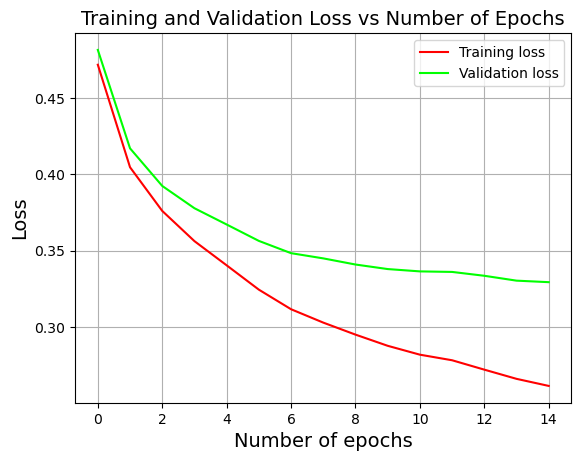

In [27]:
# Hyperparameter config3

VAL_ACCURACY_3 = 0.8838
L2_lambda_3 = 0.005
ACTIVATION_3 = "relu"
BATCH_SIZE_3 = 64
EPOCHS_3 = 15
HIDDEN_SIZE_3 = 64
INITIALIZER_3 = "xavier"
LEARNING_RATE_3 = 0.1
LOSS_3 = 'cross-entropy'
NUM_LAYERS_3 = 3
OPTIMIZER_3 = "momentum"
WEIGHT_DECAY_3 = 0.0005

# Learned parameters
learned_parameters, epoch_cost = NN_fit_w(X_train, y_train_one_hot,
                            X_val, y_val_one_hot,
                            learning_rate=LEARNING_RATE_3,
                            activation_function=ACTIVATION_3,
                            init_mode=INITIALIZER_3,
                            optimizer=OPTIMIZER_3,
                            batch_size=BATCH_SIZE_3,
                            loss=LOSS_3,
                            epochs=EPOCHS_3,
                            L2_lamb=L2_lambda_3,
                            num_layers=NUM_LAYERS_3,
                            hidden_size=HIDDEN_SIZE_3)


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch number:  2 	Training cost: 2.30252045282958
Epoch number:  4 	Training cost: 2.3024424524975275
Epoch number:  6 	Training cost: 2.302277914747517
Epoch number:  8 	Training cost: 2.301694642924494
Epoch number:  10 	Training cost: 2.2923434217907377


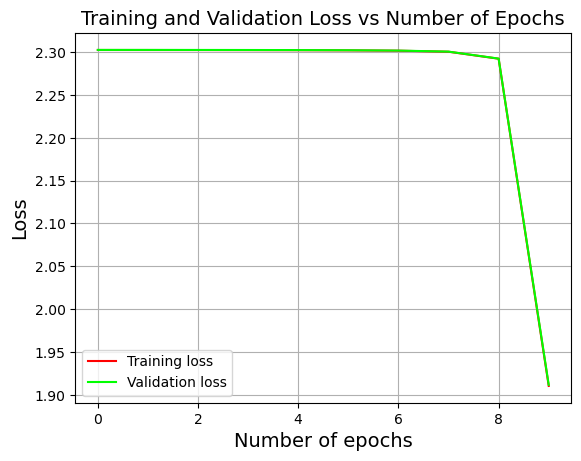

In [28]:
# config 4 - with mse

import wandb
import matplotlib.pyplot as plt

# Initialize wandb
wandb.init(project="FODL_ASSIGNMENT_01_ABHIJEET", name='with_mse')

# Your hyperparameter configuration
VAL_ACCURACY_4 = 38.37
L2_lambda_4 = 0.005
ACTIVATION_4 = "relu"
BATCH_SIZE_4 = 64
EPOCHS_4 = 10
HIDDEN_SIZE_4 = 128
INITIALIZER_4 = "random_normal"
LEARNING_RATE_4 = 0.01
LOSS_4 = 'mse'
NUM_LAYERS_4 = 5
OPTIMIZER_4 = "momentum"
WEIGHT_DECAY_4 = 0.0005

# Learned parameters (assuming you have your data)
learned_parameters, epoch_cost = NN_fit_w(X_train, y_train_one_hot,
                            X_val, y_val_one_hot,
                            learning_rate=LEARNING_RATE_4,
                            activation_function=ACTIVATION_4,
                            init_mode=INITIALIZER_4,
                            optimizer=OPTIMIZER_4,
                            batch_size=BATCH_SIZE_4,
                            loss=LOSS_4,
                            epochs=EPOCHS_4,
                            L2_lamb=L2_lambda_4,
                            num_layers=NUM_LAYERS_4,
                            hidden_size=HIDDEN_SIZE_4)

# Generate and plot your desired graph
# For example:
plt.plot(epoch_cost)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training Cost over Epochs')

# Log the plot to wandb
wandb.log({"Training Cost": plt})

# Close the wandb run
wandb.finish()


Training accuracy = 90.448 %
Test accuracy = 87.57 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.78      0.79      1000
           3       0.87      0.90      0.88      1000
           4       0.78      0.82      0.80      1000
           5       0.98      0.93      0.95      1000
           6       0.67      0.71      0.69      1000
           7       0.89      0.97      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



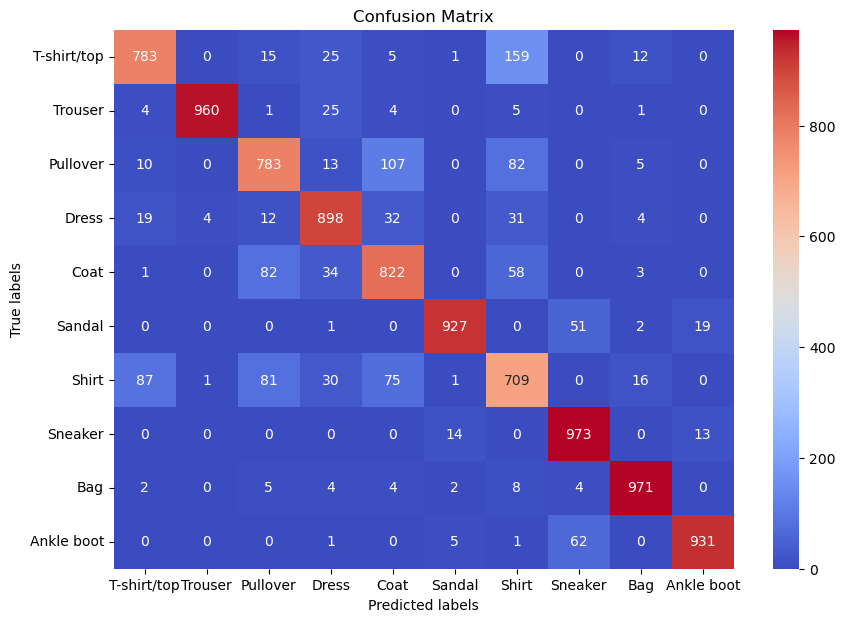

In [29]:
##########################################################################################################################

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"]

# Model Evaluation with X_test dataset
train_predictions, test_predictions = NN_evaluate(X_train, y_train, X_test, y_test, learned_parameters_best, ACTIVATION_1)
# Confusion matrix

cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


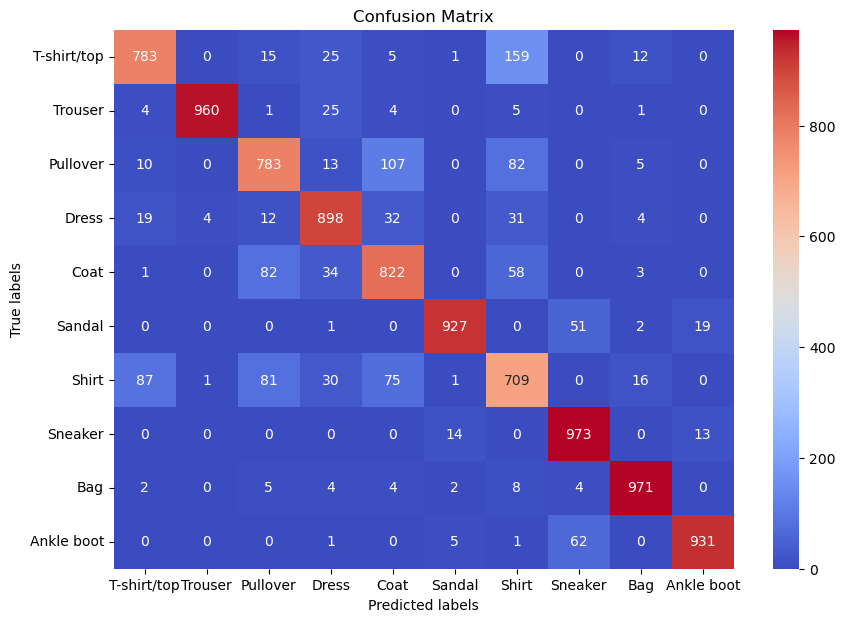

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
 
wandb.init(project="FODL_ASSIGNMENT_01_ABHIJEET")

# Generate confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Save the plot as an image file
confusion_matrix_image_path = "confusion_matrix.png"
plt.savefig(confusion_matrix_image_path)

# Log the image file to Weights & Biases
wandb.log({"Confusion Matrix": wandb.Image(confusion_matrix_image_path)})

# Show the plot
plt.show()

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training accuracy = 90.448 %
Test accuracy = 87.57 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.78      0.79      1000
           3       0.87      0.90      0.88      1000
           4       0.78      0.82      0.80      1000
           5       0.98      0.93      0.95      1000
           6       0.67      0.71      0.69      1000
           7       0.89      0.97      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



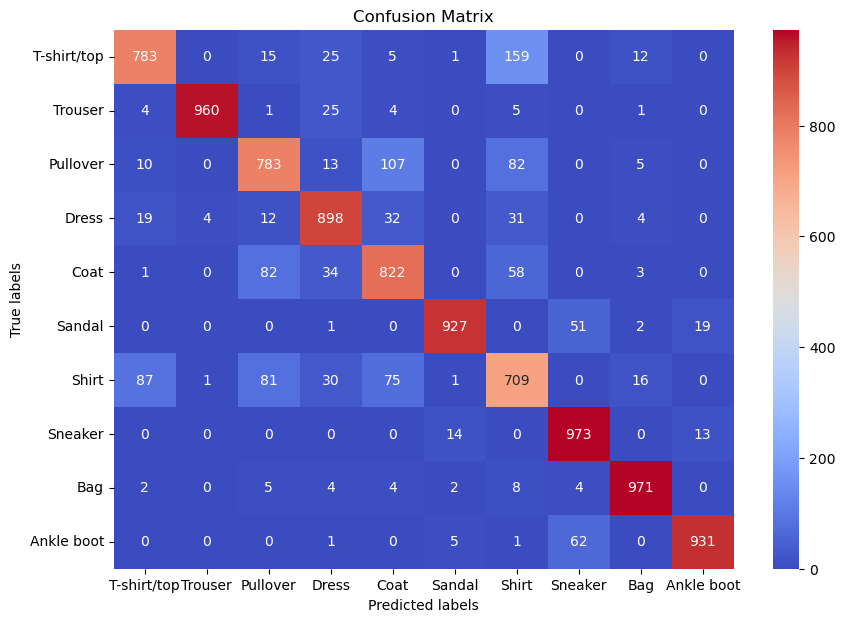

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

# Define class names
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"]

# Initialize wandb
wandb.init(project="FODL_ASSIGNMENT_01_ABHIJEET")

# Model Evaluation with X_test dataset
train_predictions, test_predictions = NN_evaluate(X_train, y_train, X_test, y_test, learned_parameters_best, ACTIVATION_1)

# Generate confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Save the plot as an image file
confusion_matrix_image_path = "confusion_matrix.png"
plt.savefig(confusion_matrix_image_path)

# Log the image file to Weights & Biases
wandb.log({"Confusion Matrix": wandb.Image(confusion_matrix_image_path)})

# Show the plot
plt.show()

# Finish wandb run
wandb.finish()
